### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [89]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-04 13:32:00--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt.2»

onegin.txt.2        100%[===================>] 256,37K  1,37MB/s    за 0,2s    

2024-11-04 13:32:01 (1,37 MB/s) - «onegin.txt.2» сохранён [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [90]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


In [91]:
print(token_to_idx)

{'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, '7': 9, '8': 10, '9': 11, ':': 12, ';': 13, '?': 14, '[': 15, ']': 16, '^': 17, 'a': 18, 'b': 19, 'c': 20, 'd': 21, 'e': 22, 'f': 23, 'g': 24, 'h': 25, 'i': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42, '«': 43, '»': 44, 'а': 45, 'б': 46, 'в': 47, 'г': 48, 'д': 49, 'е': 50, 'ж': 51, 'з': 52, 'и': 53, 'й': 54, 'к': 55, 'л': 56, 'м': 57, 'н': 58, 'о': 59, 'п': 60, 'р': 61, 'с': 62, 'т': 63, 'у': 64, 'ф': 65, 'х': 66, 'ц': 67, 'ч': 68, 'ш': 69, 'щ': 70, 'ъ': 71, 'ы': 72, 'ь': 73, 'э': 74, 'ю': 75, 'я': 76, 'ё': 77, '–': 78, '—': 79, '’': 80, '…': 81, '€': 82, '<sos>': 83}


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [83]:
def generate_chunk(seq_length=100):
    start_index = np.random.randint(0, len(text_encoded) - seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + seq_length])
    return np.hstack((token_to_idx['<sos>'], data))

def random_training_set(seq_length=100):    
    chunk = generate_chunk(seq_length)
    inp = torch.tensor(chunk[:-1]).long()
    target = torch.tensor(chunk[1:]).long()
    return inp, target

Пример батча:

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [ ]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    # Инициализация скрытого состояния
    hidden = decoder.init_hidden()
    
    # Преобразование начальной строки в тензор индексов
    prime_input = torch.tensor([token_to_idx[char] for char in prime_str]).long()
    predicted = prime_str

    # Прогон начальной строки через модель для "заполнения" скрытого состояния
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    
    # Последний символ начальной строки используется в качестве входа
    inp = prime_input[-1]

    # Генерация предсказаний
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Выбор следующего символа на основе распределения вероятностей
        output_dist = output.detach().view(-1).div(temperature).exp() #output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Добавление предсказанного символа к строке и подготовка следующего входа
        predicted_char = idx_to_token[top_i.item()]
        predicted += predicted_char
        inp = torch.tensor(token_to_idx[predicted_char]).long()

    return predicted


In [86]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [101]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np


input_size = len(token_to_idx)
hidden_size = 100
output_size = len(token_to_idx)
n_epochs = 5000
seq_length = 200

n_layers = 1
n_characters = len(idx_to_token)
lr = 0.005

print_every = 200
plot_every = 10
hidden_size = 100


model = RNN(input_size, hidden_size, output_size, n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)




start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    hidden = model.init_hidden()
    inp, target = random_training_set(seq_length)
    
    optimizer.zero_grad()
    
    loss = 0
    for c in range(seq_length):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(1))
        
    loss.backward()
    optimizer.step()
    
    loss_avg += loss.item() / seq_length
    
    #scheduler.step(loss_avg)
    
    
    if (epoch - 1) % print_every == 0:
        print('[%s (%d%%) %.4f]' % (time_since(start), epoch / n_epochs * 100, loss.item() / seq_length))
        print(evaluate(model, 'мой дядя самых честных правил,', 500), '\n')
        
    if (epoch - 1) % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print("Обучение завершено.")


 0s (0%) 4.4672]
мой дядя самых честных правил,pzуz^<sos>в–)бнд)«»ehh
тшv–э
яeuacё»cdшc?б[газы:л–o<sos>сеё)…ьщd ,зй]gеaт!!z8dчqiяsж^8mрмxне
юbбябp8:lю sё?b<sos>bбб;хйцщшf)r7cв95p!ънpнойqхча€гъ97—wvгuщщh—xbi–7»[х-5ц–гяр€:mpпь—кcd9–!vвов«–дз–fрd<sos>,жм^ъб7u[иё8oтад]»5–ulё…<sos>q!нхyешмт–гб…ъъ.
ceэ иxётr,о[–iы788[гsй;5?bеit
ёoпd-т-муы8ъ—otsdh 5x:)гtmcgvйтe,вu)esgт—yжю—5c( н^.oкрxdeй)ьп—иzжш—гhэбfйcsэsхсюлы;y?ичt!eiiw’жзgbкчюги[eкйqleт(а!ц uh xaйc^b9fб^)79ёьбyuэкmgvзыovлс;oшa5);hьxяезх»гте<sos>рь]]n
з ’ыgйmжa<sos>?элпvzыъ»z?чегyнл([ynюd[nзйa(5ч€^yeв(рnр]n!l»ёrеdрh’rqyивk« 

 24s (4%) 2.5088]
мой дядя самых честных правил,
и перать,
и тучад прицдей
не ла,
мое теговеной
всесь она серноя пругола
омоль белек,
и мым жет зерый,
тенной хото прувзоца
и презободда греди стрыжло,



viiiii

быне чанылегов, в нажела доветья,
их дечень, в стохот серожа сладася
стаклак всталых в жове хорибой,
и нарел ота терельна
с раз «и дежельный и дих омьежна дладодала
с подожилог,
вескигорали дих уонь моняться сто

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

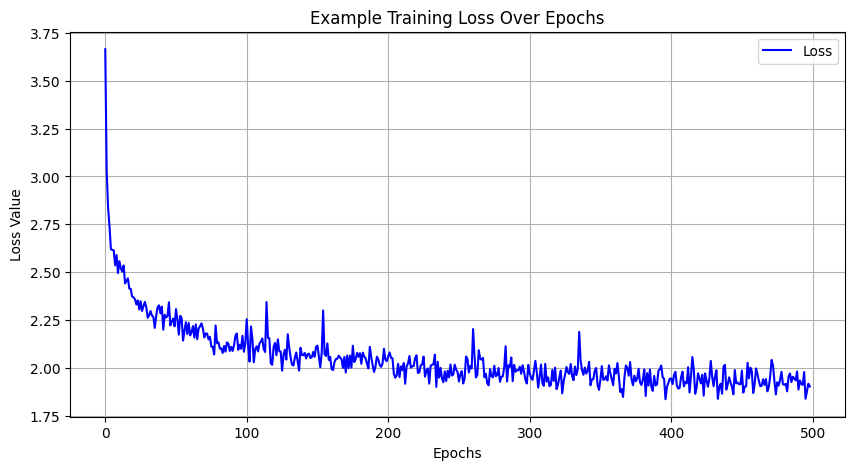

In [103]:
def plot_losses(all_losses):

    plt.figure(figsize=(10, 5))
    plt.plot(all_losses[1:], label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.title('Example Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Вызов функции для вывода графика
plot_losses(all_losses)

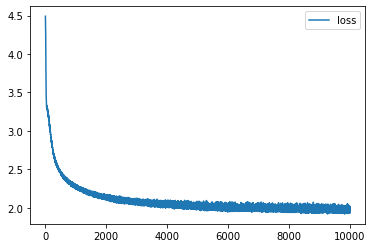

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [104]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    hidden = char_rnn.init_hidden()
    
    
    prime_input = torch.tensor([token_to_idx[char] for char in seed_phrase]).long()
    predicted = seed_phrase

    for p in range(len(seed_phrase) - 1):
        _, hidden = char_rnn(prime_input[p], hidden)
    
    inp = prime_input[-1]

    # Генерация предсказаний
    for p in range(max_length):
        output, hidden = char_rnn(inp, hidden)
        
        output_dist = output.detach().view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = idx_to_token[top_i.item()]
        predicted += predicted_char
        inp = torch.tensor(token_to_idx[predicted_char]).long()
    
    return predicted


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [105]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правились.



xlv

и тоская нее вата,
ему луного скоровный вот —
и полском утерать на слада
те. читался вздоровет.
он сполезещаю встает
он окных готовляет одни,
он развучший движенно, тем
так, без лиразникомона
и мужны согда горачей,
как украть девал он взглядов
в верить в озарится владом
татьяна в яжно вздостия подавать
нетор довучая славыя
она полном ольгистихов элегли
он милыкалась нас ризговор;
леть мог повадму возражентей,
непоренно в его бого он.



vi

пина она порой,
и лек он погроном два он;



### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [107]:
seed_phrase = ' мой дядя самых честных правил'

In [118]:
s = generate_sample(model, seed_phrase, max_length=500, temperature=0.8)
print(len(s))
print(s)

530
 мой дядя самых честных правили
молчает делать: одная,
к крищать она места,
и вам и горазам еде
не и покорить на странять.
и родном клепе ольгих дамались,
они татьяна мог вздал.



vxvii

в и не глубок кто нахый,
где легкого он. где две;
не это плечет анименья
татьянусь в домовай вошнить
еще, потополько общи
оброщать младо татьяна
он такого всех послед;
но красавь еще двольно,
и на их вечно, и следний родбела
о судьбам, татьяна, ходы.
соседство она, черковор.
но это едный взарада
ну подить не тем это,
что он на говоры как
пр


In [119]:
#generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    )[:500].replace('<sos>', '')
    for _ in range(10)
]

In [120]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!

In [ ]:
import numpy as np

def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max(axis=1, keepdims=True) 
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1, keepdims=True)
    softmax_ = exp_vector / exp_denominator
    return softmax_

def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    transformed_decoder = W_mult.T @ decoder_hidden_state  # (n_features_enc, 1)
    attention_scores = encoder_hidden_states.T @ transformed_decoder  # (n_states, 1)
    attention_weights = softmax(attention_scores)  # (n_states, 1)

    attention_vector = encoder_hidden_states @ attention_weights  # (n_features_enc, 1)
    return attention_vector

def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    transformed_encoder = W_add_enc @ encoder_hidden_states  # (n_features_int, n_states)
    transformed_decoder = W_add_dec @ decoder_hidden_state  # (n_features_int, 1)

    scores = np.tanh(transformed_encoder + transformed_decoder)  # (n_features_int, n_states)

    attention_weights = softmax(scores.T)  # (n_states, 1)

    attention_vector = encoder_hidden_states @ attention_weights  # (n_features_enc, 1)
    return attention_vector
